# Preprocess cholera outbreaks

This notebook cleans and prepares weekly cholera outbreaks data in PDF format from the [Integrated Disease Surveillance Programme of India](https://idsp.nic.in/) (IDSP) and saves it in shapefile format for further processing.

Before, the Python script `download_cholera_outbreaks_data.py` needs to be executed to download the PDF files.

Reading the PDF files and transforming them to raw text to extract the relevant information using Python didn't work too well. First converting them to raw text using the command line and then trying to extract the desired information using Python also didn't work well. Using a specialized Python package called `tabula-py` to extract tables directly from PDF files, and subsequently the desired information, worked better.

There are many challenges in extracting the desired information from the PDF files at hand, e. g. difficulties extracting raw text from PDF files in a uniform way, changing table structures, inconsistent spelling and formatting of names and dates etc.

In [1]:
# import packages
import os
import glob
import numpy as np
import pandas as pd
import tabula
import re
import geopandas as gpd
import requests
import zipfile
import io

## Load PDF files and extract relevant parts

In [2]:
# make list of desired years
years = list(np.arange(2010, 2019))

In [3]:
# set path for cholera outbreaks data
path = '../data/cholera_outbreaks'

Loop through PDF files supposedly containing cholera outbreaks and extract relevant rows.

In [5]:
%%time

outbreaks_raw = pd.DataFrame(columns=['file'])

# loop through years
for year in years:
    
    print('Processing {}...'.format(year))
    
    # get all pdf files in directory
    files = glob.glob(os.path.join(path, str(year), '*.pdf'))

    # loop through files
    for file in files:

        # read tables from pdf
        tables = tabula.read_pdf(file, pages='all', stream=True, silent=True) # How can I be sure that no rows are askew?

        # loop through tables
        for table in tables:

            # get columns containing cholera
            cholera_columns = [column for column in table if table[column].astype(str).str.lower().str.contains('cholera', na=False).any()]

            # proceed only if there are any columns containing cholera
            if len(cholera_columns) > 0:

                # loop through columns containing cholera
                for cholera_column in cholera_columns:

                    # get rows containing cholera
                    table_temp = table[table[cholera_column].astype(str).str.lower().str.contains('cholera', na=False)]

                    # proceed only if there are any rows containing cholera
                    if len(table_temp) > 0:

                        # rename columns
                        column_names = []
                        for i in range(table_temp.shape[1]):
                            column_names.append('col'+str(i))
                        table_temp.columns = column_names

                        # add file
                        table_temp = table_temp.reset_index(drop=True)
                        table_temp['file'] = file.split('/')[-1]

                        # add extracted rows to previously created dataframe
                        outbreaks_raw = pd.concat([outbreaks_raw, table_temp], axis=0).reset_index(drop=True)

2010
../data/cholera_outbreaks/2010/31st_2010.pdf
../data/cholera_outbreaks/2010/3rd_2010.pdf
../data/cholera_outbreaks/2010/5th_2010.pdf
../data/cholera_outbreaks/2010/42nd_2010.pdf
../data/cholera_outbreaks/2010/39th_2010.pdf
../data/cholera_outbreaks/2010/41st_2010.pdf
../data/cholera_outbreaks/2010/27th_2010.pdf
../data/cholera_outbreaks/2010/53rd_2010.pdf
../data/cholera_outbreaks/2010/9th_2010.pdf
../data/cholera_outbreaks/2010/33rd_2010.pdf
../data/cholera_outbreaks/2010/25th_2010.pdf
../data/cholera_outbreaks/2010/28th_2010.pdf
../data/cholera_outbreaks/2010/14th_2010.pdf
../data/cholera_outbreaks/2010/47th_2010.pdf
../data/cholera_outbreaks/2010/21st_2010.pdf
../data/cholera_outbreaks/2010/8th_2010.pdf
../data/cholera_outbreaks/2010/17th_2010.pdf
../data/cholera_outbreaks/2010/40th_2010.pdf
../data/cholera_outbreaks/2010/1st_2010.pdf
../data/cholera_outbreaks/2010/52nd_2010.pdf
../data/cholera_outbreaks/2010/6th_2010.pdf
../data/cholera_outbreaks/2010/35th_2010.pdf
../data/cho

In [6]:
outbreaks_raw.shape

(1992, 20)

In [7]:
outbreaks_raw.head()

,file,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18
0,31st_2010.pdf,5.,Pradesh,Shimla,Cholera,235/ 1*,13.07.10,control,"affected area, five samples found contaminated...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31st_2010.pdf,NaN,Himachal,NaN,NaN,NaN,NaN,Under,V. cholerae (Ogawa serotype) and 9 for Esch. c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31st_2010.pdf,8.,Rajasthan,Jaipur,Cholera,1095/0,20.07.10,surveillance,"SMS Medical College, 18 samples showed growth ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31st_2010.pdf,8.,Rajasthan,Jaipur,Cholera,1095/0,20.07.10,surveillance,"SMS Medical College, 18 samples showed growth ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42nd_2010.pdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unfit for drinking and stool sample was negati...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preprocess raw cholera outbreaks.

In [8]:
# drop duplicates
outbreaks_raw = outbreaks_raw.drop_duplicates().reset_index(drop=True)

In [9]:
# make column with file names last column in dataframe
new_cols = [col for col in outbreaks_raw.columns if col != 'file'] + ['file']
outbreaks_raw = outbreaks_raw[new_cols]

In [10]:
# fill na
outbreaks_raw = outbreaks_raw.fillna('')

In [11]:
# make all columns lower case
outbreaks_raw = outbreaks_raw.apply(lambda x: x.astype(str).str.lower())

In [12]:
outbreaks_raw.shape

(1902, 20)

In [13]:
outbreaks_raw.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
0,5.,pradesh,shimla,cholera,235/ 1*,13.07.10,control,"affected area, five samples found contaminated...",,,,,,,,,,,,31st_2010.pdf
1,,himachal,,,,,under,v. cholerae (ogawa serotype) and 9 for esch. c...,,,,,,,,,,,,31st_2010.pdf
2,8.,rajasthan,jaipur,cholera,1095/0,20.07.10,surveillance,"sms medical college, 18 samples showed growth ...",,,,,,,,,,,,31st_2010.pdf
3,,,,,,,,,,unfit for drinking and stool sample was negati...,,,,,,,,,,42nd_2010.pdf
4,,,,disease found to be not potable and two stool ...,,,,,,,,,,,,,,,,42nd_2010.pdf


## Filter cholera outbreaks

In [19]:
# check which columns contain cholera
cholera_columns = [column for column in outbreaks_raw if outbreaks_raw[column].str.contains('cholera').any()]
cholera_columns

['col0',
 'col1',
 'col2',
 'col3',
 'col4',
 'col5',
 'col6',
 'col7',
 'col8',
 'col9',
 'col10',
 'col11',
 'col12',
 'col13',
 'col14',
 'col18']

In [20]:
# check which columns contain how many cholera rows
for cholera_column in cholera_columns:
    print('Number of cholera rows in {}: {}'.format(cholera_column, outbreaks_raw[outbreaks_raw[cholera_column].str.contains('cholera')].shape[0]))

Number of cholera rows in col0: 143
Number of cholera rows in col1: 35
Number of cholera rows in col2: 118
Number of cholera rows in col3: 593
Number of cholera rows in col4: 69
Number of cholera rows in col5: 7
Number of cholera rows in col6: 12
Number of cholera rows in col7: 84
Number of cholera rows in col8: 369
Number of cholera rows in col9: 456
Number of cholera rows in col10: 48
Number of cholera rows in col11: 32
Number of cholera rows in col12: 14
Number of cholera rows in col13: 2
Number of cholera rows in col14: 1
Number of cholera rows in col18: 1


Check each column supposedly containing cholera outbreaks and decide whether it can be dropped.

In [63]:
outbreaks_raw.shape

(1898, 20)

In [54]:
outbreaks_filtered_main = outbreaks_raw[(outbreaks_raw['col1'].str.contains('cholera')) |
                                        (outbreaks_raw['col2'].str.contains('cholera')) |
                                        (outbreaks_raw['col3'].str.contains('cholera')) |
                                        (outbreaks_raw['col4'].str.contains('cholera'))]
outbreaks_filtered_main.shape

(807, 20)

In [61]:
outbreaks_filtered_other = outbreaks_raw[(~outbreaks_raw['col1'].str.contains('cholera')) &
                                        (~outbreaks_raw['col2'].str.contains('cholera')) &
                                        (~outbreaks_raw['col3'].str.contains('cholera')) &
                                        (~outbreaks_raw['col4'].str.contains('cholera'))]
outbreaks_filtered_other.shape

(1091, 20)

In [64]:
outbreaks_filtered_other[outbreaks_filtered_other['col0'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
10,collected and sent to microbiology deptt. gmch...,,,,,,,,,,,,,,,,,,,41st_2010.pdf
108,cholerae. out of 10 water samples sent for tes...,haryana,gurgaon,under diarrhoeal 155 / 0 10.07.10,,,,,,,,,,,,,,,,29th_2010.pdf
120,investigated the outbreak. stool samples were ...,gadag,diarrhoeal,25 / 0,11.07.11,16.07.11,under,,,,,,,,,,,,,28th_2011.pdf
918,cholera,,,,,,,,,,,,,,,,,,,23rd_2014.pdf
963,cholera,,,,,,,,,,,,,,,,,,,38th_2014.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,cholera,,,,,,,,,,,,,,,,,,,51th_2018.pdf
1873,cholera,,,,,,,,,,,,,,,,,,,44th_2018.pdf
1882,cholera,,,,,,,,,,,,,,,,,,,46th_2018.pdf
1890,cholera,,,,,,,,,,,,,,,,,,,47th_2018.pdf


In [65]:
outbreaks_filtered_other[outbreaks_filtered_other['col5'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
379,,,,,investigated the outbreak. samples tested posi...,for v.cholerae in,,,,,,,,,,,,,,25th_2012.pdf
460,,,,,,35 0 06/06/12 control potable. out of 3 stool ...,,,,,,,,,,,,,,26th_2012.pdf
733,3.,,,hooghly,,xvi cholera,,,,,,,,,,,,,,2nd_2013.pdf
915,,,,,,vibrio cholerae. 02 water samples tested and,found non potable.,,,,,,,,,,,,,42nd_2014.pdf
1049,,,,,,negative for cholera by culture. alternate sou...,,,,,,,,,,,,,,39th_2014.pdf
1773,,,,,for v.,cholera,culture.,,cases,treated,,,,,,,,,,28th_2018.pdf


In [66]:
outbreaks_filtered_other[outbreaks_filtered_other['col6'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
29,,,disease,,,,found unsatisfactory. water and stool samples ...,,,,,,,,,,,,,47th_2010.pdf
83,,,,,,,positive for v. cholerae o1 el tor (ogawa). de...,,,,,,,,,,,,,37th_2010.pdf
85,,,,,,,for v. cholerae o1 (ogawa). control measures u...,,,,,,,,,,,,,37th_2010.pdf
196,,,,,,,outbreak. stool samples tested positive for v....,,,,,,,,,,,,,40th_2011.pdf
268,,,,,,under,samples tested negative for vibrio cholera. wa...,,,,,,,,,,,,,46th_2011.pdf
409,,gujarat bharuch,30,0,05/12/11,,at chc valia. 2 stool samples collected which ...,,,,,,,,,,,,,1st_2012.pdf
562,1.,,khammam,,70 0 15/05/12 under control team investigated ...,for,cholera,,,,,,,,,,,,,21st_2012.pdf
624,,,,,,,"samples collected, 1 sample was positive for c...",,,,,,,,,,,,,29th_2013.pdf
924,,,,,,,symptomatically. 4 stool samples tested negati...,,,,,,,,,,,,,23rd_2014.pdf
946,,,,,,,"sent to jjmc davangere, 03 tested positive for...",,,,,,,,,,,,,22nd_2014.pdf


In [67]:
outbreaks_filtered_other[outbreaks_filtered_other['col7'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
1,,himachal,,,,,under,v. cholerae (ogawa serotype) and 9 for esch. c...,,,,,,,,,,,,31st_2010.pdf
15,,,,,,,surveillance,"karnal, out of which one found positive for vi...",,,,,,,,,,,,27th_2010.pdf
19,,,,,,,,samples tested positive for v. cholerae and al...,,,,,,,,,,,,27th_2010.pdf
20,,,,,,,,v.cholerae. health education given regarding h...,,,,,,,,,,,,27th_2010.pdf
21,,,,,,,,v.cholerae. health education given regarding h...,,,,,,,,,,,,27th_2010.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,,,,,,,,bankura; one was positive for vibrio cholera o1,,,,,,,,,,,,25th_2016.pdf
1558,,,,,,,,vibrio cholera. out of 04 water samples tested,,,,,,,,,,,,24th_2016.pdf
1559,,,,,,,,for v cholera and all 03 water samples found,,,,,,,,,,,,24th_2016.pdf
1712,,,,,,,,for vibrio cholera and water samples tested non,,,,,,,,,,,,35th_2017.pdf


In [68]:
outbreaks_filtered_other[outbreaks_filtered_other['col8'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
28,,,,,,,,surveillance,"culture, of which 2 tested positive for choler...",,,,,,,,,,,25th_2010.pdf
42,6.,rajasthan,bhilwara,diarrhoeal,84 / 0,18.08.10,20.08.10,under control,ruled out cholera and found common commensals....,,,,,,,,,,,35th_2010.pdf
62,,,,,,,,under,water. stool samples from 30 cases tested posi...,,,,,,,,,,,10th_2010.pdf
63,,,,,,,,under,samples tested negative for v. cholerae. water...,,,,,,,,,,,20th_2010.pdf
64,,,,,,,,control,cholera. water tested not potable. disinfectio...,,,,,,,,,,,20th_2010.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,,,,,,,,,growth of vibrio cholerae (o1 ogawa). 5 water,,,,,,,,,,,11th_2018.pdf
1867,,,,,,,,,surveillance medical college dahod found chole...,,,,,,,,,,,32nd_2018.pdf
1884,,,,,,,,,"rphl, found negative for cholera culture. 4 wa...",,,,,,,,,,,46th_2018.pdf
1885,,,,,,,,,control stool samples were negative for choler...,,,,,,,,,,,30th_2018.pdf


In [69]:
outbreaks_filtered_other[outbreaks_filtered_other['col9'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
3,,,,,,,,,,unfit for drinking and stool sample was negati...,,,,,,,,,,42nd_2010.pdf
9,,,,,,,stool,samples tested,,positive for cholera. alternative safe drinkin...,made,,,,,,,,,39th_2010.pdf
23,,,,,,,,,,"14 found positive for vibrio cholerae (el tor,...",,,,,,,,,,53rd_2010.pdf
88,,,,,,,,,,positive for v. cholera (el tor ogawa). 4 wate...,,,,,,,,,,22nd_2010.pdf
197,,,,,,,,,control,shimoga medical college were found negative fo...,,,,,,,,,,2nd_2011.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,,,,,,,,,surveillance,cholera o1 ogawa) found; other sample,,,,,,,,,,44th_2018.pdf
1887,,,,,,,,,,culture shows growth of vibrio cholera,,,,,,,,,,23rd_2018.pdf
1892,,,,,,,,,,done. 01 stool sample was negative for cholera,,,,,,,,,,38th_2018.pdf
1893,,,,,,,,,,negative for cholera culture. all cases treated,,,,,,,,,,38th_2018.pdf


In [70]:
outbreaks_filtered_other[outbreaks_filtered_other['col10'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
38,,,,disease,,,,,samples tested,for,cholera found negative. iec activities,undertaken,,,,,,,,52nd_2010.pdf
330,,,,,disease,38,0,04/08/12,12/08/12,,hospital lab karnal which tested negative for ...,,,,,,,,,32nd_2012.pdf
334,,,,,,,,,,,tested positive for cholera. chlorine tablets ...,,,,,,,,,32nd_2012.pdf
343,,,rangareddy,i,food poisoning,70,1,10/05/12,13/05//12,,contaminated food. stool samples tested negati...,,,,,,,,,20th_2012.pdf
376,,,,,,,,,,negative for,v.cholerae by culture. chlorination of water,,,,,,,,,25th_2012.pdf
383,,,,,,,,,,,showed growth of virbrio cholerae (o1 ogwa). 2...,,,,,,,,,29th_2012.pdf
410,,,,,,,,,,under,stool samples collected were negative for chol...,,,,,,,,,22nd_2012.pdf
411,,,,,,,,,,under,outbreak. stool samples collected were negativ...,,,,,,,,,22nd_2012.pdf
438,,,,,,,,,,control,guwahati which tested negative for cholera cul...,,,,,,,,,34th_2012.pdf
442,,,,,,,,,,positive for,cholera. chlorination of water sources done.,,,,,,,,,34th_2012.pdf


In [71]:
outbreaks_filtered_other[outbreaks_filtered_other['col11'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
114,,,davangere,,50 / 0,05.06.11,07.06.11,,"davanagere,",samples,,were negative for cholera culture.,cases,treated,,,,,,23rd_2011.pdf
179,,,,,,,,under,"referral lab,",samples,,found to be negative for cholera by hanging drop,,,,,,,,25th_2011.pdf
285,,,,,poisoning,,,,surveillance,"microbiology dept. gmch,",,guwahati found negative for cholera.,,,,,,,,48th_2011.pdf
311,,,,,,,,,,microbiology,deptt.,gmch tested positive for cholera. 108,,,,,,,,23rd_2012.pdf
312,,,,,26,0,04/06/12,05/06/12,control,district,public,health laboratory tested negative for cholera.,,,,,,,,23rd_2012.pdf
349,,,,,,,,,,out of which,3 samples,were positive for vibrio cholerae,by,,,,,,,45th_2012.pdf
355,,,,,,,,,,samples,showed,growth of vibrio cholerae and,,,,,,,,31st_2012.pdf
403,,,haveri,diarrhoeal,62,,05/01/12,07/01/12,,outbreak.,stool,samples collected were negative for cholera,,,,,,,,1st_2012.pdf
479,,,,,,,,,surveillance,one sample,sent,for stool culture tested positive for v. cholerae,,,,,,,,5th_2012.pdf
489,,,,,,,,,under,"madurai,",2,samples tested positive for cholera culture. 4,,cases,,,,,,3rd_2012.pdf


In [72]:
outbreaks_filtered_other[outbreaks_filtered_other['col12'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
105,,,,,,,,"microbiology,",igmc,,"shimla, 5 samples tested positive",for,v. cholerae,,,,,,,29th_2010.pdf
161,,,kolar,diarrhoeal,21 /1,05.03.11,15.03.11,,and investigated,the,outbreak. stool samples tested negative,for,cholera.,,,,,,,11th_2011.pdf
499,,,,,,,,,,sample was,,positive,for cholera culture. control measures,,,,,,,38th_2012.pdf
500,,,,,,,,,,samples,collected,,1 sample was positive for cholera,culture.,,,,,,38th_2012.pdf
502,,,,,,,,,,samples tested,,positive,for vibrio cholerae by culture. chlorine,,,,,,,38th_2012.pdf
728,,,,,,,,,,collected,,were negative,for cholera culture. out of 34,water,,,,,,46th_2013.pdf
749,,,,,,,,,,was,negative,,for cholera culture. disinfection of,,,,,,,36th_2013.pdf
826,,,,disease,,,,,,which tested,,negative,"for cholera. further, 1 stool sample",,,,,,,24th_2013.pdf
837,,,,disease,,,,,,collected,,were negative,for cholera culture. 6 water samples,,,,,,,39th_2013.pdf
862,,nagaon,diarrhoeal,39,1,09/09/13,09/09/13,,female.,6,stool,samples collected were negative for,cholera,,,,,,,37th_2013.pdf


In [27]:
outbreaks_filtered_other[outbreaks_filtered_other['col13'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
153,,,,,disease,,,,sent to golaghat district priority lab under,,,idsp found negative,for,cholera,,,,,,39th_2011.pdf
236,,,,,,,,,,outbreak.,2,stool,samples,collected and tested negative for cholera. health,,,,,,38th_2011.pdf


In [28]:
outbreaks_filtered_other = outbreaks_filtered_other[outbreaks_filtered_other['col13'].str.contains('cholera') == False]
outbreaks_filtered_other.shape

(1898, 20)

In [23]:
outbreaks_filtered_other[outbreaks_filtered_other['col14'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
1813,,,,,,,,control,three stool,samples,tested,in,gmc,reported,cholera,in,,,,27th_2018.pdf


In [24]:
outbreaks_filtered_other = outbreaks_filtered_other[outbreaks_filtered_other['col14'].str.contains('cholera') == False]
outbreaks_filtered_other.shape

(1901, 20)

In [25]:
outbreaks_filtered_other[outbreaks_filtered_other['col18'].str.contains('cholera')]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,file
1677,,,,,,,,,,,,,,,,,,,positive for cholera by hanging drop method. all,52nd_2017.pdf


In [26]:
outbreaks_filtered_other = outbreaks_filtered_other[outbreaks_filtered_other['col18'].str.contains('cholera') == False]
outbreaks_filtered_other.shape

(1900, 20)

## Extract and clean start dates

Now we need to extract and clean the start dates of outbreaks. We know that the start date of an outbreak is supposed to be mentioned right next to the number of cases and/or deaths.

In [20]:
# clean columns suspected to contain start dates
for col in outbreaks.columns[5:8]:
    outbreaks[col+'_clean'] = outbreaks[col].apply(lambda x: None if re.search('[a-zA-Z]', str(x)) is not None
                                                   else (None if len(str(x)) < 4
                                                         else x.replace('(', '').replace(')', '').replace('*', '')))

In [21]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10
3,growth,of,vibrio,cholera,01,on,culture,at,None,2010/39th_2010.pdf,cholera,1,None,None,None
4,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10


In [22]:
# extract the first date mentioned from the suspected columns
start_dates = []

for i, row in outbreaks.iterrows():
    dates = row[12:]
    start_date = next((i for i in dates if i is not None), None)
    start_dates.append(start_date)

In [23]:
outbreaks['start_date'] = start_dates

In [24]:
# check extracted start dates
outbreaks['start_date'].unique()

array(['13.07.10', '20.07.10', '10.09.10', None, '06.09.10', '24.09.10',
       '03.07.10', '24.06.10', '29.06.10', '27.06.10', '19.12.10',
       '29.07.10', '15.06.10', '04.11.10', '10.05.10', '21.09.10',
       '28.12.09', '11.12.10', '24.01.10', '17.08.10', '16.07.10',
       '27.05.10', '30.05.10', '22.10.10', '03.10.10', '20.08.10',
       '18.08.10', '28.02.10', '04.06.10', '24.10.10', '22.06.10',
       '29.11.10', '16.08.10', '06.08.10', '12.05.10', '03.05.10',
       '23.04.10', '12.07.10', '06.07.10', '06.06.11', '08.07.11',
       '27.06.11', '26.06.11', '03.03.11', '13.07.11', '15.10.11',
       '24.10.11', '23.09.11', '01.10.11', '08.03.11', '08.12.11',
       '11.12.11', '23.04.11', '18.04.11', '24.04.11', '07.04.11',
       '20.06.11', '14.06.11', '20.02.11', '11.07.11', '23.07.11',
       '20.04.11', '07.10.11', '03.01.11', '12.12.11', '14.10.11',
       '09.09.11', '22.08.11', '18.08.11', '20.08.11', '16.08.11',
       '21.08.11', '14.08.11', '20.03.11', '15.09.11', '

We see that the dates appear in many different formats. Thus, we should harmonise them.

In [25]:
# drop all rows that do not contain any date
outbreaks = outbreaks.loc[outbreaks['start_date'].notnull()].reset_index(drop=True)

In [26]:
# harmonise date formats to extract year
outbreaks['year'] = outbreaks['start_date'].apply(lambda x: x.split('.')[2] if '.' in x
                                                  else (x.split('/')[2] if '/' in x
                                                        else (x.split('-')[2] if '-' in x
                                                              else x)))

In [27]:
# further harmonise date formats and extract years
outbreaks['year'] = outbreaks['year'].str.pad(width=3, side='left', fillchar='0')
outbreaks['year'] = outbreaks['year'].str.pad(width=4, side='left', fillchar='2')
outbreaks['year'] = outbreaks['year'].astype(np.int64)

In [28]:
# check years
sorted(outbreaks['year'].unique())

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [29]:
# check case where there seems to be a typo
outbreaks.loc[(outbreaks['col9'] == '2015/39th_2015.pdf') & (outbreaks['year'] == 2019)]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year
393,karnataka,bagalkot,vii.,cholera,66,00,20-09-19,25-09-19,None,2015/39th_2015.pdf,cholera,1,None,20-09-19,25-09-19,20-09-19,2019


In [30]:
# fix typo
outbreaks.loc[(outbreaks['col9'] == '2015/39th_2015.pdf') & (outbreaks['year'] == 2019), 'year'] = 2015

In [31]:
# harmonise date formats to extract month
outbreaks['month'] = outbreaks['start_date'].apply(lambda x: x.split('.')[1] if '.' in x
                                                   else (x.split('/')[1] if '/' in x
                                                         else (x.split('-')[1] if '-' in x
                                                               else x)))

In [32]:
# cast month to integer
outbreaks['month'] = outbreaks['month'].astype(np.int64)

In [33]:
# check months
sorted(outbreaks['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [34]:
outbreaks.shape

(587, 18)

In [35]:
# drop all rows that do not contain data from 2010 to 2018
outbreaks = outbreaks.loc[outbreaks['year'].isin(years)].reset_index(drop=True)
outbreaks.shape

(586, 18)

In [36]:
outbreaks

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,pb/ldh/2018/44/1456,punjab,ludhiana,cholera,12,00,12-09-18,under,None,2018/44th_2018.pdf,cholera,1,None,12-09-18,None,12-09-18,2018,9
582,west,bengal,bardhaman,cholera,69,00,02-06-18,04-06-18,None,2018/23rd_2018.pdf,cholera,1,None,02-06-18,04-06-18,02-06-18,2018,6
583,basis.,ch/chd/2018/22/760,chandigarh,cholera,01,00,23-05-18,under,None,2018/23rd_2018.pdf,cholera,1,None,23-05-18,None,23-05-18,2018,5
584,kl/mlp/2018/08/0241,kerala,malappuram,cholera,03,00,01-02-18,under,None,2018/8th_2018.pdf,cholera,1,None,01-02-18,None,01-02-18,2018,2


## Map states, districts and location

Next, we need to map states and districts to their geographic location. We do this with the help of the [Database of Global Administrative Areas](https://www.gadm.org/index.html). We download the Level 2 administrative zones for India and explore them before we extract the relevant information and merge it with the outbreaks data.

In [37]:
!wget --recursive --no-directories --no-clobber --directory-prefix=../data/cholera_outbreaks https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip

File ‘../data/cholera_outbreaks/gadm36_IND_shp.zip’ already there; not retrieving.



In [38]:
!unzip -u -d ../data/cholera_outbreaks/gadm36_IND_shp ../data/cholera_outbreaks/gadm36_IND_shp.zip

Archive:  ../data/cholera_outbreaks/gadm36_IND_shp.zip


In [39]:
path = '../data/cholera_outbreaks/gadm36_IND_shp'

In [40]:
file = 'gadm36_IND_2.shp'

In [41]:
india = gpd.read_file(os.path.join(path, file))

In [42]:
# check crs
india.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
india.shape

(666, 14)

In [44]:
india.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      666 non-null    object  
 1   NAME_0     666 non-null    object  
 2   GID_1      666 non-null    object  
 3   NAME_1     666 non-null    object  
 4   NL_NAME_1  0 non-null      object  
 5   GID_2      666 non-null    object  
 6   NAME_2     666 non-null    object  
 7   VARNAME_2  190 non-null    object  
 8   NL_NAME_2  0 non-null      object  
 9   TYPE_2     666 non-null    object  
 10  ENGTYPE_2  666 non-null    object  
 11  CC_2       0 non-null      object  
 12  HASC_2     626 non-null    object  
 13  geometry   666 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 73.0+ KB


In [45]:
india.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.1_1,Nicobar Islands,None,None,District,District,None,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.2_1,North and Middle Andaman,None,None,District,District,None,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.3_1,South Andaman,None,None,District,District,None,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",None,District,District,None,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.2_1,Chittoor,Chitoor|Chittor,None,District,District,None,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."


<AxesSubplot:>

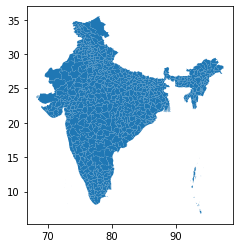

In [46]:
india.plot()

In [47]:
# select states, districts and geometry
states_districts = india[['NAME_1', 'NAME_2', 'geometry']].copy()

In [48]:
# rename columns
states_districts.columns = ['state', 'district', 'geometry']

In [49]:
# make states and districts lowercase to simplify the mapping
states_districts['state'] = states_districts['state'].str.lower()
states_districts['district'] = states_districts['district'].str.lower()

In [50]:
# create list with unique districts
districts = states_districts['district'].unique().tolist()

In [51]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9


In [52]:
# remove all but alphanumeric characters from columns suspected to contain states and districts
for col in outbreaks.columns[0:3]:
    outbreaks[col+'_clean'] = outbreaks[col].apply(lambda x: re.sub('\W', '', x))
    outbreaks[col+'_clean'] = outbreaks[col+'_clean'].apply(lambda x: None if len(x) < 3 else x)

In [53]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii


In [54]:
# harmonise district names in col1_clean to simplify mapping
outbreaks.loc[outbreaks['col1_clean'] == 'mahabubnagar', 'col1_clean'] = 'mahbubnagar'
outbreaks.loc[outbreaks['col1_clean'] == 'ahmedabad', 'col1_clean'] = 'ahmadabad'
outbreaks.loc[outbreaks['col1_clean'] == 'howrah', 'col1_clean'] = 'haora'
outbreaks.loc[outbreaks['col1_clean'] == 'hooghly', 'col1_clean'] = 'hugli'
outbreaks.loc[outbreaks['col1_clean'] == 'hoogly', 'col1_clean'] = 'hugli'
outbreaks.loc[outbreaks['col1_clean'] == 'villupuram', 'col1_clean'] = 'viluppuram'
outbreaks.loc[outbreaks['col1_clean'] == 'haridwar', 'col1_clean'] = 'hardwar'
outbreaks.loc[outbreaks['col1_clean'] == 'davangere', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'davengere', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'davangare', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'tiruchirapalli', 'col1_clean'] = 'tiruchirappalli'
outbreaks.loc[outbreaks['col1_clean'] == 'darang', 'col1_clean'] = 'darrang'
outbreaks.loc[outbreaks['col1_clean'] == 'virudhunager', 'col1_clean'] = 'virudunagar'
outbreaks.loc[outbreaks['col1_clean'] == 'chikkaballapur', 'col1_clean'] = 'chikballapura'
outbreaks.loc[outbreaks['col1_clean'] == 'gondia', 'col1_clean'] = 'gondiya'
outbreaks.loc[outbreaks['col1_clean'] == 'purulia', 'col1_clean'] = 'puruliya'
outbreaks.loc[outbreaks['col1_clean'] == 'kalaburagi', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'kalburgi', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'gulburga', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'berhampur', 'col1_clean'] = 'ganjam'
outbreaks.loc[outbreaks['col1_clean'] == 'sholapur', 'col1_clean'] = 'solapur'
outbreaks.loc[outbreaks['col1_clean'] == 'raigad', 'col1_clean'] = 'raigarh'
outbreaks.loc[outbreaks['col1_clean'] == 'panchmahal', 'col1_clean'] = 'panch mahals'
outbreaks.loc[outbreaks['col1_clean'] == 'sibsagar', 'col1_clean'] = 'sivasagar'
outbreaks.loc[outbreaks['col1_clean'] == 'banaskantha', 'col1_clean'] = 'banas kantha'
outbreaks.loc[outbreaks['col1_clean'] == 'chamarajnagar', 'col1_clean'] = 'chamrajnagar'
outbreaks.loc[outbreaks['col1_clean'] == 'khargaon', 'col1_clean'] = 'west nimar'
outbreaks.loc[outbreaks['col1_clean'] == 'mysuru', 'col1_clean'] = 'mysore'
outbreaks.loc[outbreaks['col1_clean'] == 'mohali', 'col1_clean'] = 'sahibzada ajit singh nagar'
outbreaks.loc[outbreaks['col1_clean'] == 'delhi', 'col1_clean'] = 'west'
outbreaks.loc[outbreaks['col1_clean'] == 'kawardha', 'col1_clean'] = 'kabeerdham'
outbreaks.loc[outbreaks['col1_clean'] == 'chirtadurga', 'col1_clean'] = 'chitradurga'
outbreaks.loc[outbreaks['col1_clean'] == 'budgam', 'col1_clean'] = 'badgam'
outbreaks.loc[outbreaks['col1_clean'] == 'jangir', 'col1_clean'] = 'janjgir-champa'
outbreaks.loc[outbreaks['col1_clean'] == 'kancheepuramsaidapet', 'col1_clean'] = 'kancheepuram'

# harmonise district names in col2_clean to simplify mapping
outbreaks.loc[outbreaks['col2_clean'] == 'thiruvannamalai', 'col2_clean'] = 'tiruvannamalai'
outbreaks.loc[outbreaks['col2_clean'] == 'raigad', 'col2_clean'] = 'raigarh'
outbreaks.loc[outbreaks['col2_clean'] == 'davangere', 'col2_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col2_clean'] == 'sibsagar', 'col2_clean'] = 'sivasagar'
outbreaks.loc[outbreaks['col2_clean'] == 'sabarkantha', 'col2_clean'] = 'sabar kantha'

In [55]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii


In [56]:
outbreaks.columns[18:]

Index(['col0_clean', 'col1_clean', 'col2_clean'], dtype='object')

In [57]:
# extract district strings from columns suspected to contain districts
for col in outbreaks.columns[18:]:
    outbreaks[col+'_district'] = outbreaks[col].apply(lambda x: None if x is None else next((d for d in districts if x in str(d)), None))

In [58]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla,None,None,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi,None,dibrugarh,None
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi,None,belgaum,None
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii,None,bharuch,None


In [59]:
# select processed columns suspected to contain districts
district_cols = [col for col in outbreaks.columns if 'district' in col]

In [60]:
# extract districts from processed columns suspected to contain districts
outbreaks_districts = []

for i, row in outbreaks.iterrows():
    all_district_cols = row[district_cols]
    district = next((i for i in all_district_cols if i is not None), None)
    outbreaks_districts.append(district)

In [61]:
# create new column with extracted districts
outbreaks['district'] = outbreaks_districts

In [62]:
# manually map missing districts
outbreaks.loc[(outbreaks['col4'] == '110') & (outbreaks['col6'] == '25/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '50') & (outbreaks['col6'] == '25/10/13') & (outbreaks['col7'] == '28/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '23') & (outbreaks['col6'] == '23/10/13') & (outbreaks['col7'] == '23/10/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '13') & (outbreaks['col6'] == '31/07/13') & (outbreaks['col7'] == '31/07/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '33') & (outbreaks['col6'] == '01/06/13') & (outbreaks['col7'] == '08/06/13'), 'district'] = 'chitradurga'
outbreaks.loc[(outbreaks['col4'] == '88') & (outbreaks['col6'] == '05/05/13'), 'district'] = 'sangli'
outbreaks.loc[(outbreaks['col4'] == '60') & (outbreaks['col6'] == '01/05/13') & (outbreaks['col7'] == '02/05/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '36') & (outbreaks['col6'] == '19/04/13'), 'district'] = 'davanagere'
outbreaks.loc[(outbreaks['col4'] == '161') & (outbreaks['col6'] == '27/08/12'), 'district'] = 'nagpur'
outbreaks.loc[(outbreaks['col4'] == '73') & (outbreaks['col6'] == '22/07/12') & (outbreaks['col7'] == '23/07/12'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '19') & (outbreaks['col6'] == '21/07/12') & (outbreaks['col7'] == '21/07/12'), 'district'] = 'chikmagalur'
outbreaks.loc[(outbreaks['col4'] == '21') & (outbreaks['col6'] == '06/07/12') & (outbreaks['col7'] == '12/07/12'), 'district'] = 'birbhum'
outbreaks.loc[(outbreaks['col4'] == '59') & (outbreaks['col6'] == '25/05/12') & (outbreaks['col7'] == '25/05/12'), 'district'] = 'tumkur'
outbreaks.loc[(outbreaks['col4'] == '8') & (outbreaks['col6'] == '03/05/12') & (outbreaks['col7'] == '07/05/12'), 'district'] = 'wayanad'
outbreaks.loc[(outbreaks['col4'] == '26') & (outbreaks['col7'] == '16.08.11'), 'district'] = 'birbhum'
outbreaks.loc[(outbreaks['col4'] == '86') & (outbreaks['col6'] == '25/10/13') & (outbreaks['col7'] == '28/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '25') & (outbreaks['col6'] == '19/05/12'), 'district'] = 'mandya'
outbreaks.loc[(outbreaks['col4'] == '12') & (outbreaks['col6'] == '13.03.12') & (outbreaks['col7'] == '14.03.12'), 'district'] = 'mysore'

In [63]:
outbreaks

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla,None,None,shimla,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur,alwar,sikar,jaipur,alwar
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi,None,dibrugarh,None,dibrugarh
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi,None,belgaum,None,belgaum
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii,None,bharuch,None,bharuch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,pb/ldh/2018/44/1456,punjab,ludhiana,cholera,12,00,12-09-18,under,None,2018/44th_2018.pdf,cholera,1,None,12-09-18,None,12-09-18,2018,9,pbldh2018441456,punjab,ludhiana,None,None,ludhiana,ludhiana
582,west,bengal,bardhaman,cholera,69,00,02-06-18,04-06-18,None,2018/23rd_2018.pdf,cholera,1,None,02-06-18,04-06-18,02-06-18,2018,6,west,bengal,bardhaman,west godavari,None,None,west godavari
583,basis.,ch/chd/2018/22/760,chandigarh,cholera,01,00,23-05-18,under,None,2018/23rd_2018.pdf,cholera,1,None,23-05-18,None,23-05-18,2018,5,basis,chchd201822760,chandigarh,None,None,chandigarh,chandigarh
584,kl/mlp/2018/08/0241,kerala,malappuram,cholera,03,00,01-02-18,under,None,2018/8th_2018.pdf,cholera,1,None,01-02-18,None,01-02-18,2018,2,klmlp2018080241,kerala,malappuram,None,None,malappuram,malappuram


In [64]:
outbreaks.shape

(586, 25)

In [65]:
# keep only rows that have a district
outbreaks = outbreaks.loc[outbreaks['district'].notnull()]
outbreaks.shape

(564, 25)

In [66]:
# map states and geometry to districts
outbreaks_mapped = pd.merge(states_districts, outbreaks, how='right', on='district')[['state', 'district', 'year', 'month', 'outbreak', 'geometry']].reset_index(drop=True)
outbreaks_mapped.shape

(573, 6)

In [67]:
outbreaks_mapped

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."
...,...,...,...,...,...,...
568,punjab,ludhiana,2018,9,1,"POLYGON ((76.07124 30.56471, 76.06435 30.56714..."
569,andhra pradesh,west godavari,2018,6,1,"POLYGON ((81.81902 16.66214, 81.83632 16.64615..."
570,chandigarh,chandigarh,2018,5,1,"POLYGON ((76.80293 30.67548, 76.79437 30.66932..."
571,kerala,malappuram,2018,2,1,"POLYGON ((76.06149 10.72085, 76.05975 10.71879..."


In [68]:
# find districts with identical names appearing in different states
duplicate_districts = states_districts['district'].value_counts()[states_districts['district'].value_counts() > 1].index.tolist()
outbreaks_mapped[outbreaks_mapped['district'].isin(duplicate_districts)].sort_values('district')

,state,district,year,month,outbreak,geometry
517,maharashtra,aurangabad,2017,11,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
446,maharashtra,aurangabad,2016,7,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
516,bihar,aurangabad,2017,11,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
445,bihar,aurangabad,2016,7,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
163,chhattisgarh,bijapur,2012,8,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
164,karnataka,bijapur,2012,8,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
199,chhattisgarh,bijapur,2012,7,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
200,karnataka,bijapur,2012,7,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
443,chhattisgarh,bijapur,2016,3,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
444,karnataka,bijapur,2016,3,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."


We need to check to which state the duplicated districts actually belong.

In [69]:
outbreaks.loc[(outbreaks['district'] == 'aurangabad') & (outbreaks['month'] == 11)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
530,mh/agb/2017/46/1591,maharashtra,aurangabad,cholera,5825,00,10-11-17,13-11-17,None,2017/46th_2017.pdf,cholera,1,None,10-11-17,13-11-17,10-11-17,2017,11,mhagb2017461591,maharashtra,aurangabad,None,None,aurangabad,aurangabad


In [70]:
outbreaks.loc[(outbreaks['district'] == 'aurangabad') & (outbreaks['month'] == 7)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
448,mh/agb/2016/27/1592,maharashtra,aurangabad,cholera,09,01,08-07-16,09-07-16,None,2016/27th_2016.pdf,cholera,1,None,08-07-16,09-07-16,08-07-16,2016,7,mhagb2016271592,maharashtra,aurangabad,None,None,aurangabad,aurangabad


In [71]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 8)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
162,given.,bijapur,xvi,cholera,85,0,20/08/12,20/08/12,None,2012/34th_2012.pdf,cholera,1,None,20/08/12,20/08/12,20/08/12,2012,8,given,bijapur,xvi,None,bijapur,None,bijapur


In [72]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 7)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
197,imparted.,bijapur,xi,cholera,32,0,08/07/12,12/07/12,None,2012/28th_2012.pdf,cholera,1,None,08/07/12,12/07/12,08/07/12,2012,7,imparted,bijapur,None,None,bijapur,None,bijapur


In [73]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 8)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
162,given.,bijapur,xvi,cholera,85,0,20/08/12,20/08/12,None,2012/34th_2012.pdf,cholera,1,None,20/08/12,20/08/12,20/08/12,2012,8,given,bijapur,xvi,None,bijapur,None,bijapur


In [74]:
outbreaks.loc[(outbreaks['district'] == 'pratapgarh') & (outbreaks['month'] == 7)] # rajasthan

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
487,rj/pgr/2016/30/1789,rajasthan,pratapgarh,cholera,49,00,29-07-16,29-07-16,None,2016/30th_2016.pdf,cholera,1,None,29-07-16,29-07-16,29-07-16,2016,7,rjpgr2016301789,rajasthan,pratapgarh,None,None,pratapgarh,pratapgarh


In [75]:
outbreaks.loc[(outbreaks['district'] == 'raigarh') & (outbreaks['month'] == 7)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
72,maharashtra,raigad,xxii,cholera,67,/,0,11.07.11,None,2011/29th_2011.pdf,cholera,1,None,None,11.07.11,11.07.11,2011,7,maharashtra,raigarh,xxii,None,raigarh,None,raigarh
98,week.,11,raigad,cholera,94,/,0,11.07.11,None,2011/30th_2011.pdf,cholera,1,None,None,11.07.11,11.07.11,2011,7,week,None,raigarh,None,None,raigarh,raigarh


In [76]:
outbreaks.loc[(outbreaks['district'] == 'raigarh') & (outbreaks['month'] == 3)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
386,maharashtra,raigad,xxxi.,cholera,22,00,30/03/15,under,None,2015/16th_2015.pdf,cholera,1,None,30/03/15,None,30/03/15,2015,3,maharashtra,raigarh,xxxi,None,raigarh,None,raigarh


We figured out to which state the duplicated districts actually belong and drop the rows that contain wrong data.

In [77]:
outbreaks_mapped = outbreaks_mapped.drop(outbreaks_mapped.loc[(outbreaks_mapped['state'].isin(['bihar', 'chhattisgarh', 'uttar pradesh'])) & (outbreaks_mapped['district'].isin(['aurangabad', 'bijapur', 'raigarh', 'pratapgarh']))].index)
outbreaks_mapped.shape

(564, 6)

In [78]:
outbreaks_mapped.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."


We drop duplicated rows since we want to count an outbreak only once per district and month.

In [79]:
outbreaks_deduplicated = outbreaks_mapped.drop_duplicates().reset_index(drop=True)
outbreaks_deduplicated.shape

(466, 6)

## Create expanded dataframe to include months with no cholera outbreaks

In [80]:
n_districts = outbreaks_mapped[['state', 'district']].drop_duplicates().shape[0]
n_years = outbreaks_deduplicated['year'].nunique()
n_months = outbreaks_deduplicated['month'].nunique()

In [81]:
states_districts_expanded = pd.concat([outbreaks_deduplicated[['state', 'district', 'geometry']].drop_duplicates()] * n_years * n_months).sort_values(by=['district']).reset_index(drop=True)
states_districts_expanded.shape

(19224, 3)

In [82]:
states_districts_expanded.head(109)

,state,district,geometry
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
...,...,...,...
104,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
105,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
106,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
107,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."


In [83]:
years_df = pd.DataFrame(columns=['year'])

for year in sorted(outbreaks_deduplicated['year'].unique()):
    years_df_temp = pd.concat([outbreaks_deduplicated[outbreaks_deduplicated['year'] == year][['year']].drop_duplicates()] * n_months)
    years_df = pd.concat([years_df, years_df_temp], axis=0)

years_expanded = pd.concat([years_df[['year']]] * n_districts).reset_index(drop=True)
years_expanded['year'] = years_expanded['year'].astype(int)
years_expanded.shape

(19224, 1)

In [84]:
years_expanded.head(13)

,year
0,2010
1,2010
2,2010
3,2010
4,2010
5,2010
6,2010
7,2010
8,2010
9,2010


In [85]:
months_expanded = pd.concat([outbreaks_deduplicated[['month']].drop_duplicates().sort_values(by='month')] * n_years * n_districts).reset_index(drop=True)
months_expanded.shape

(19224, 1)

In [86]:
months_expanded.head(13)

,month
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [87]:
# concat expanded districts, years and months
expanded_df = pd.concat([states_districts_expanded, years_expanded, months_expanded], axis=1).reset_index(drop=True)
expanded_df.shape

(19224, 5)

In [88]:
expanded_df.head()

,state,district,geometry,year,month
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,1
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,2
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,3
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,4
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,5


In [89]:
# merge expanded dataframe and deduplicated outbreaks
outbreaks_final = pd.merge(expanded_df, outbreaks_deduplicated.drop_duplicates(), how='left', on=['state', 'district', 'geometry', 'year', 'month']).reset_index(drop=True)
outbreaks_final.shape

(19224, 6)

In [90]:
outbreaks_final.head()

,state,district,geometry,year,month,outbreak
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,1,NaN
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,2,NaN
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,3,NaN
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,4,NaN
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,5,NaN


In [91]:
outbreaks_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19224 entries, 0 to 19223
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   state     19224 non-null  object  
 1   district  19224 non-null  object  
 2   geometry  19224 non-null  geometry
 3   year      19224 non-null  int64   
 4   month     19224 non-null  int64   
 5   outbreak  466 non-null    float64 
dtypes: float64(1), geometry(1), int64(2), object(2)
memory usage: 901.2+ KB


In [92]:
outbreaks_final['outbreak'] = outbreaks_final['outbreak'].fillna(0)
outbreaks_final['outbreak'] = outbreaks_final['outbreak'].astype(int)
outbreaks_final['outbreak'].value_counts()

0    18758
1      466
Name: outbreak, dtype: int64

Finally, we save the data in shapefile format.

In [93]:
%%time

outbreaks_final.to_file('../data/cholera_outbreaks/monthly_cholera_outbreaks_per_district_2010_2018.shp')

CPU times: user 1min 19s, sys: 1.39 s, total: 1min 20s
Wall time: 1min 20s
